In [1]:
import numpy as np
import numpy.linalg as ln

class StreamFeatWeight:
    """
    Streaming update of feature weights at time t
    Input  : Yt: m by nt matrix, 
             B : sketch matrix size m by l
    Output : Feature importance score
    """
   
    def __init__(self, m, k, l=0):
        """
        m : no of features initially
        k : no of singular vectors (this can be the same as the number of clusters in the dataset)
        l : sketch size for a sketched matrix B( m-by-l )
        """

        self.m = m
        self.k = k
        if l < 1: self.l = int(np.sqrt(self.m))
        else: self.l = l

    def low_rank_approximation(self, Yt):
        """
        Calculation of low rank approximation
        sketched matrix B is updated on basis of new inputs at timestep t
        
        :param Yt: m-by-nt input matrix from data stream 
        Yt is the data items introduced at time step t
        
        output: weight of each feature
        """
        #Step 1
        # combine current sketched matrix with input at time t(Yt)
       
        if hasattr(self, 'B'): #(object, name)
            C = np.hstack((self.B, Yt)) # C is m by (n+l) matrix
            n = Yt.shape[1] # it will be n_t
        else:
            # an initial sketch matrix for Y0
            self.B = Yt[:, :self.l]
            C = np.hstack((self.B, Yt[:, self.l:]))
            n = Yt.shape[1] - self.l
        
        # Step 2 :Singular value decomposition
        U, s, V = ln.svd(C, full_matrices=False)  
        
        U = U[:, :self.l]
        s = s[:self.l]
        V = V[:, :self.l]
     
        # Step 3 : shrink singular values in Frequent Directions algorithm
       
        delta = s[-1] ** 2 #shrink values on the basis of squared smallest singlar value
        s = np.sqrt(s ** 2 - delta)

        # Step 4 : update sketched matrix B
    
        self.B = np.dot(U, np.diag(s))

        # In Section 5.1, for all experiments,
        # the authors have set alpha = 2^3 * sigma_k based on the pre-experiment
        alpha = (2 ** 3) * s[self.k-1]

        # Step 5: solving the ridge regression by using the top-k singular values
       
        D = np.diag(s[:self.k] / (s[:self.k] ** 2 + alpha))
        #step 6: X: m by k matrix (k <= l)
        X = np.dot(U[:, :self.k], D)
        
        #step 7: returning maximum value of X
        return np.amax(abs(X), axis=1)

In [2]:
# paint mnist
import matplotlib.pyplot as plt

def paint_digit(digit_values):
    plt.figure()
    plt.imshow(digit_values.reshape(28,28))
    plt.gray()
    plt.xticks([])
    plt.yticks([])
    
    plt.show

In [10]:
from skmultiflow.data import FileStream
from skmultiflow.neural_networks import PerceptronMask
from sklearn.metrics import accuracy_score

stream = FileStream('datasets/Multiclass/mnist_train_normalized.csv', target_idx=0)
stream.prepare_for_use()


In [11]:
predictor = PerceptronMask()
x,y = stream.next_sample(batch_size=100)
predictor.partial_fit(x,y, stream.target_values)

PerceptronMask(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
               fit_intercept=True, max_iter=1000, n_iter_no_change=5,
               n_jobs=None, penalty=None, random_state=0, shuffle=True,
               tol=0.001, validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
fsds = StreamFeatWeight(m=stream.n_features, k=stream.n_classes)
fsds.low_rank_approximation(x.T)
print("ball")

ball


In [13]:
n_selected_ftr = 100

while stream.has_more_samples():
    # Load a new sample
    x, y = stream.next_sample(batch_size=100)

    # Select features
    ftr_weights = fsds.low_rank_approximation(x.T) 
    ftr_selection = np.argsort(ftr_weights)[::-1][:n_selected_ftr]

    # Truncate x (retain only selected features, 'remove' all others, e.g. by replacing them with 0)
    x_reduced = np.zeros(x.shape)
    x_reduced[:, ftr_selection] = x[:, ftr_selection]

    # Test
    y_pred = predictor.predict(x_reduced)
    #print(accuracy_score(y, y_pred))

    # Train
    predictor.partial_fit(x_reduced, y)

# Restart the FileStream
stream.restart()

In [15]:
selected_features = np.zeros((784))
selected_features[ftr_selection] = 1

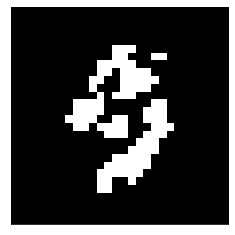

In [16]:
paint_digit(selected_features)